In [130]:
'''
Finger flexion prediction using regular machine learning models
@author: Deng Chijun
@date: 2024.11.24

'''
import logging
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [131]:
'''
load data
'''
root_dir = '/Users/miaolab/Desktop/dengchijun/coursework/bci'
os.chdir(root_dir)

## subid
subid = 3

### load data
data_process_dir = f'{root_dir}/BCI_Competion4_dataset4_data_fingerflexions/preprocessing/sub{subid}'

# train
X_train = np.load(f'{data_process_dir}/train/ecog_data.npy')
y_train_all = np.load(f'{data_process_dir}/train/fingerflex_data.npy')

# test
X_test = np.load(f'{data_process_dir}/val/ecog_data.npy')
y_test_all = np.load(f'{data_process_dir}/val/fingerflex_data.npy')

# corr feature
X_train_corr = CorrMatrix(X_train)
X_test_corr = CorrMatrix(X_test)

## reshape data
X_train = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2]).transpose(1, 0)
X_test = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2]).transpose(1, 0)

# Select specific finger
y_train = y_train_all.transpose(1, 0)
y_test = y_test_all.transpose(1, 0)


In [132]:
'''
model, train and evaluation 
'''
# Initialize the XGBRegressor
xgb = XGBRegressor(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # Learning rate
    max_depth=3,           # Maximum depth of a tree
    subsample=0.8,         # Fraction of samples used for fitting individual trees
    colsample_bytree=0.8,  # Fraction of features used for fitting individual trees
    random_state=42
)

# Initialize the LGBMRegressor
lgbm = LGBMRegressor(
    n_estimators=100,       # Number of trees
    learning_rate=0.05,     # Reduced learning rate
    max_depth=-1,           # No depth limit
    min_data_in_leaf=10,    # Minimum samples per leaf
    subsample=0.8,          # Use 80% of data for training each tree
    colsample_bytree=0.8,   # Use 80% of features for training each tree
    random_state=42
)


# Multi-output regression with GridSearchCV
model = MultiOutputRegressor(xgb)
model_name = 'XGBoost'

# fit
model.fit(X_train, y_train)

# Evaluate on testing set
y_pred = model.predict(X_test)


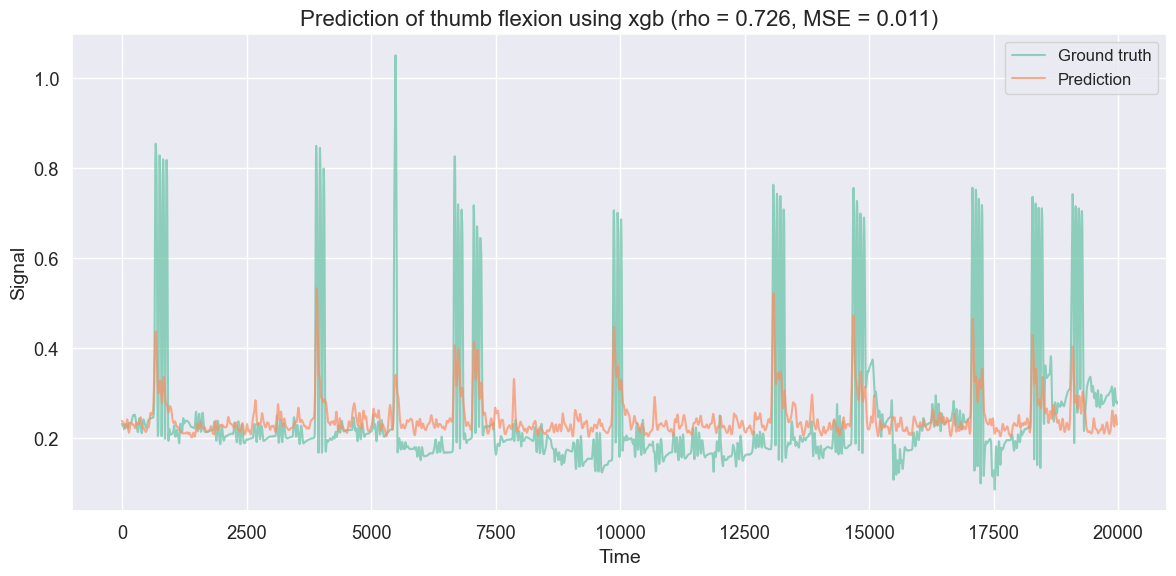

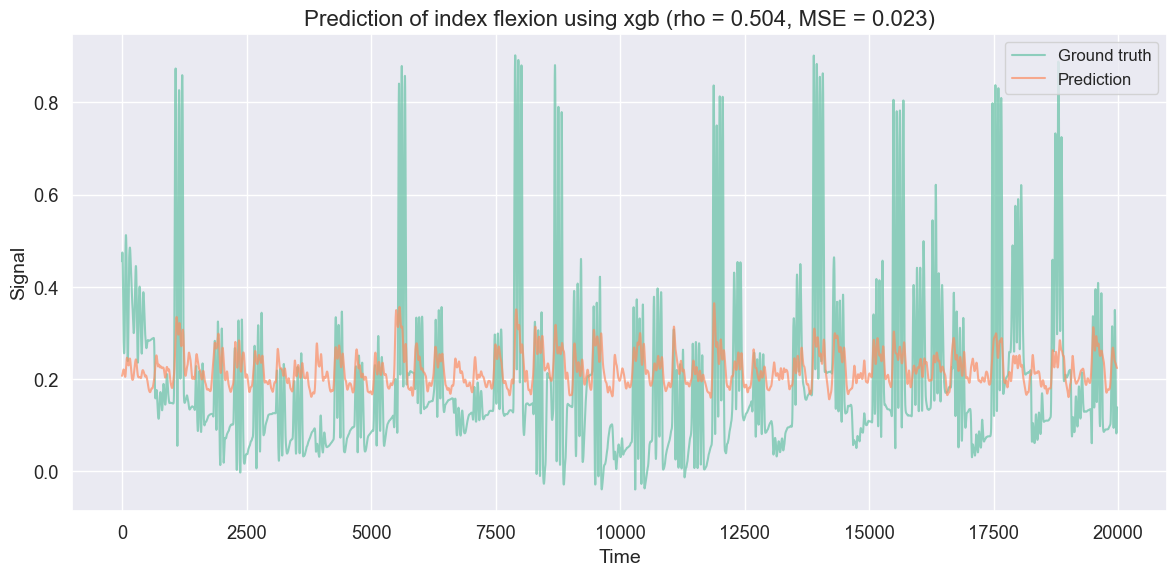

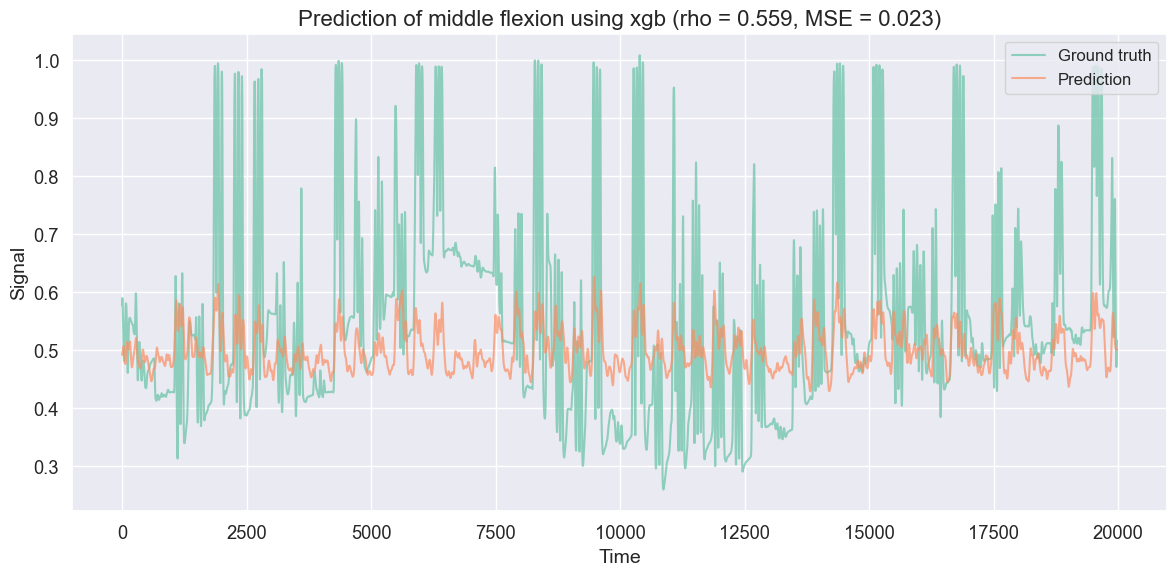

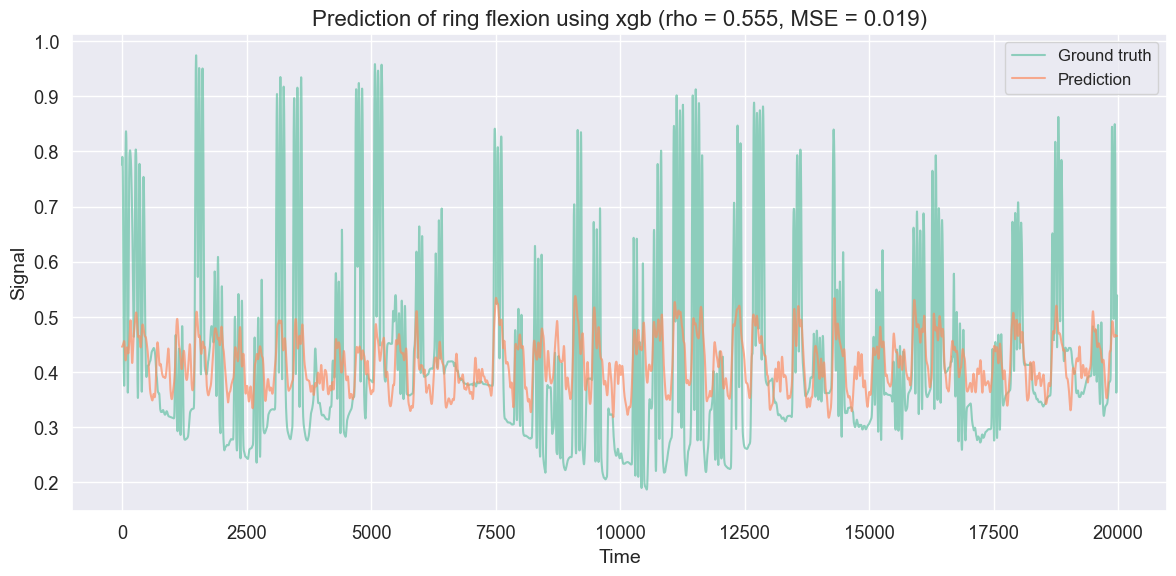

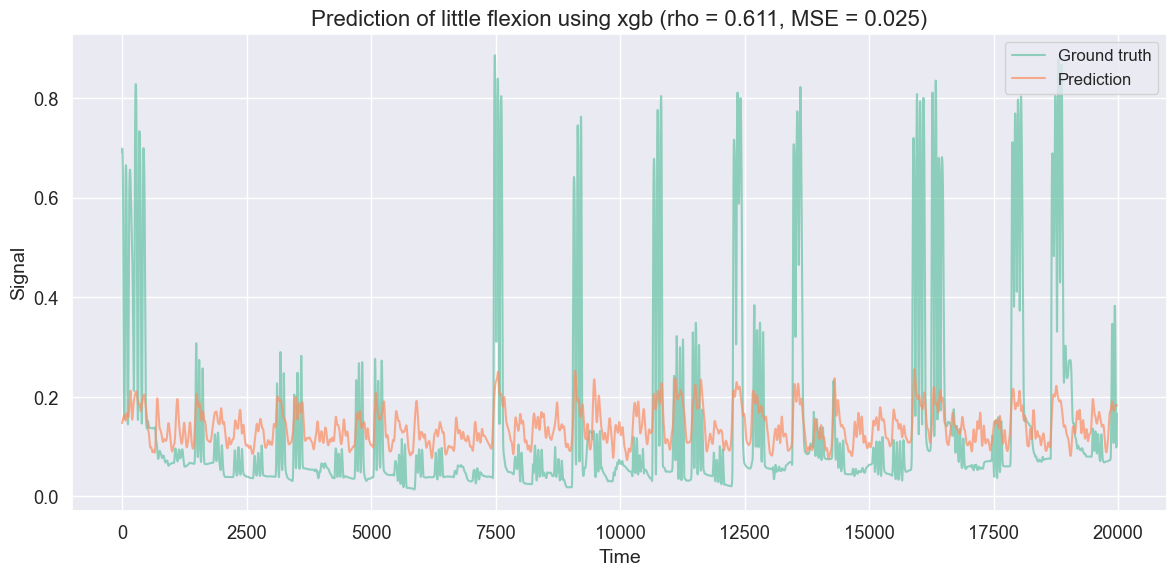

In [133]:
'''
Calculate Pearson correlation, MSE for each finger
'''
fingers = ['thumb', 'index', 'middle', 'ring', 'little']
sigma = 15 

for finger_id, finger_name in enumerate(fingers):
    
    y_test_single = y_test[:, finger_id].ravel()
    y_pred_single = y_pred[:, finger_id].ravel()
    
    # filter outputs
    y_pred_filter = gaussian_filter1d(y_pred_single, sigma=sigma)
    # metrics
    rho, _ = pearsonr(y_test_single, y_pred_filter)
    mse = mean_squared_error(y_test_single, y_pred_filter)

    '''
    Visualize
    '''
    sns.set_theme(style='darkgrid', font_scale=1.2)
    # Define a color palette
    colors = sns.color_palette("Set2", 2) 
    # Plot original y vs. predicted y
    plt.figure(figsize=(12, 6))
    
    # Plot original y
    plt.plot(y_test_single, label="Ground truth", alpha=0.7, color=colors[0])
    
    # Plot predicted y
    plt.plot(y_pred_filter.ravel(), label="Prediction", alpha=0.7, color=colors[1])
    
    # Adding labels and legend
    plt.title(f"Prediction of {finger_name} flexion using {model_name} (rho = {rho:.3f}, MSE = {mse:.3f})", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Signal", fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()